We are going to analyse the number of atoms in a MOT using fluoresence imaging.

This is a VERY rough estimate and should only be trusted to within an order of magnitude or so

We proceed following Heathers `Simplified system for creating a BEC`

In [ ]:
# Define SI unit prefixes
nm = nHz = nA = nV = nW = 1e-9
um = uHz = uA = uV = uW = 1e-6
mm = mHz = mA = mV = mW = 1e-3
cm = 1e-2
Hz = A = V = W = 1
kHz = kA = kV = kW = 1e3
MHz = MA = MV = MW = 1e6
GHz = GA = GV = GW = 1e9

In [3]:
import numpy as np

inch = 2.54 * cm

# fundamental constants
I_SAT = 3.846 * mW / cm**2

# MOT constants
D2_LINEWIDTH = 6.065 * MHz
TRAP_WAVELENGTH = 780.24 * nm
UNCOATED_INTERFACES = 0

# photodiode constants
RESPONSIVITY = 0.585  # A/W
GAIN = 4.75e6  # V/A in high-Z

In [4]:
def scatteringRate(Io, Isat, detuning, linewidth=D2_LINEWIDTH):
    """
    Calculate `R` the scattering rate of atoms in the MOT.

    All values should be in SI units.
    """
    I = Io / Isat
    return I * np.pi * linewidth / (1 + I + 4 * (detuning / linewidth) ** 2)


def solidAngle(lensDiameter, distanceFromMOT):
    """
    Calculate the solid angle of a lens of diameter `lensDiameter` at a distance `distanceFromMOT` from the MOT.

    All values should be in SI units.
    """
    lensArea = np.pi * (lensDiameter / 2) ** 2
    totalArea = 4 * np.pi * distanceFromMOT**2
    return 4 * np.pi * lensArea / totalArea


def photonEnergy(laserWavelength):
    """
    Calculate the energy of a photon with wavelength `laserWavelength`.

    All values should be in SI units.
    """
    return 6.62607015e-34 * 2.99792458e8 / laserWavelength


def photoCurrent(voltage, gain=GAIN):
    """
    Calculate the photocurrent from a photodiode with voltage `voltage`.

    All values should be in SI units.
    """
    return voltage / gain


def I0(totalPower):
    """
    Calculate the intensity of the trapping laser

    we assume the totalPower is shared across 4 beams, then two are retroreflected

    Each beam is assumed to be a 1 inch circle

    All values should be in SI units.
    """
    totalArea = 6 * np.pi * (0.5 * inch) ** 2
    return 6 / 4 * totalPower / totalArea

In [5]:
VOLTAGE_DIFF = (2.25-0.5) * V
TRAPPING_POWER = 77 * mW

solidangle = solidAngle(1 * inch, 18 * cm)
photocurrent = photoCurrent(VOLTAGE_DIFF)
photonenergy = photonEnergy(TRAP_WAVELENGTH)
scatteringrate = scatteringRate(I0(TRAPPING_POWER), I_SAT, 10 * MHz)

print(f"solid angle: {solidangle:.3f} sr")
print(f"photocurrent: {photocurrent:.2e} A")
print(f"photon energy: {photonenergy:.2e} J")
print(f"scattering rate: {scatteringrate/MHz:.2f} MHz")

solid angle: 0.016 sr
photocurrent: 3.68e-07 A
photon energy: 2.55e-19 J
scattering rate: 1.46 MHz


In [6]:
atomNumber = 4 * np.pi * photocurrent
atomNumber /= (
    solidangle
    * RESPONSIVITY
    * photonenergy
    * scatteringrate
    * 0.96**UNCOATED_INTERFACES
)

print(f"{atomNumber:.2e} atoms in the MOT")

1.36e+09 atoms in the MOT


Okay this is going to be a rough attempt at extracting fit values from imaged clouds. We will pull the data straight out of the Artiq dataset so expect some wrangling to get it looking nice

In [6]:
from artiq.frontend.artiq_master import DatasetDB

db = DatasetDB("/home/ae19663/artiq/dataset_db.mdb")
temp = {k: v[1] for k, v in db.data.raw_view.items()}


def rot_and_flip(arr):
    """
    Rotate and flip the array to match the original dataset.
    """

    return np.rot90(np.flip(arr, 1))


import numpy as np

# temp = np.load("dataset.npy", allow_pickle=True).item()
# # upgrade any arrays of uint16 to float64 - first check they are ndarrays
# for key in temp:
#     if type(temp[key]) == np.ndarray and temp[key].dtype == np.uint16:
#         temp[key] = temp[key].astype(np.float64)

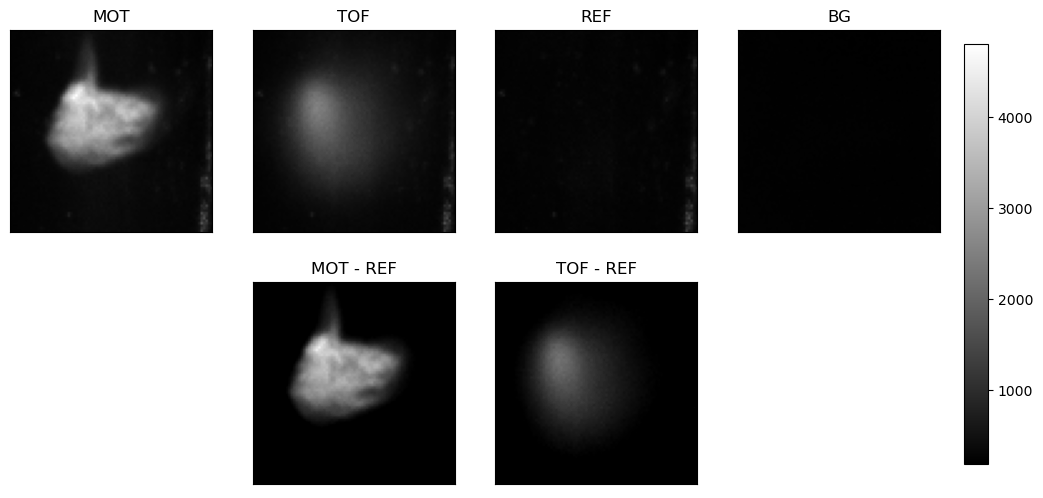

In [7]:
import matplotlib.pyplot as plt

# plot the images for Images.{MOT, TOF, REF, BG}
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

imgs = {
    "MOT": temp["Images.fluorescence.MOT"],
    "TOF": temp["Images.fluorescence.TOF"],
    "REF": temp["Images.fluorescence.REF"],
    "BG": temp["Images.fluorescence.BG"],
}
imgs = {k: rot_and_flip(v) for k, v in imgs.items()}

# vmin/vmax to share cbar
vmin = min([imgs[k].min() for k in imgs.keys()])
vmax = max([imgs[k].max() for k in imgs.keys()])

for i, name in enumerate(imgs.keys()):
    axs[0, i].imshow(imgs[name], vmin=vmin, vmax=vmax, cmap="grey")
    axs[0, i].set_title(name)

# subtract the reference image from the MOT and time of flight image
mot = imgs["MOT"] - imgs["REF"]
tof = imgs["TOF"] - imgs["REF"]

# plot the subtracted images
axs[1, 1].imshow(mot, vmin=vmin, vmax=vmax, cmap="grey")
axs[1, 1].set_title("MOT - REF")
axs[1, 2].imshow(tof, vmin=vmin, vmax=vmax, cmap="grey")
axs[1, 2].set_title("TOF - REF")

axs[1, 0].axis("off")
axs[1, 3].axis("off")

for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

# cbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(
    axs[0, 0].imshow(imgs["MOT"], vmin=vmin, vmax=vmax, cmap="grey"),
    cax=cbar_ax,
)

plt.show()

Okay we appear to at least have clean imaging of the cloud, that's a starting point.

Now we should try getting the centroid and widths

This is heavily AI inspired ;\)

In [8]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset, **kwargs):
    """2D Gaussian function with correct rotation."""
    x, y = xy
    x = x - x0
    y = y - y0

    # Rotation transformation
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    x_rot = cos_theta * x + sin_theta * y
    y_rot = -sin_theta * x + cos_theta * y

    exponent = (x_rot**2 / (2 * sigma_x**2)) + (y_rot**2 / (2 * sigma_y**2))
    gaussian = offset + amplitude * np.exp(-exponent)

    return gaussian


def fit_gaussian_2d(data, **kwargs):
    """Fit a 2D Gaussian to the given data array."""
    ny, nx = data.shape
    y, x = np.indices((ny, nx))  # Create coordinate grids

    # Initial parameter estimates
    amplitude = data.max() - data.min()
    x0, y0 = np.unravel_index(np.argmax(data), data.shape)  # Peak position
    sigma_x, sigma_y = nx / 4, ny / 4
    theta = 0  # Start with no rotation
    offset = data.min()

    initial_guess = (amplitude, x0, y0, sigma_x, sigma_y, theta, offset)
    bounds = (
        (0, -1, -1, 0, 0, -np.pi, -np.inf),  # Lower bounds
        (np.inf, nx + 1, ny + 1, nx, ny, np.pi, np.inf),  # Upper bounds
    )

    # ravel for fitting
    def gaussian_2d_ravel(xy, *args):
        return gaussian_2d(xy, *args).ravel()

    # Fit using curve_fit
    popt, pcov = opt.curve_fit(
        gaussian_2d_ravel,
        (x.ravel(), y.ravel()),
        data.ravel(),
        p0=initial_guess,
        bounds=bounds,
    )

    # limit theta to -pi to pi

    params = {
        "amplitude": popt[0],
        "x0": popt[1],
        "y0": popt[2],
        "sigma_x": popt[3],
        "sigma_y": popt[4],
        "theta": popt[5],
        "offset": popt[6],
    }

    # pcov is the covariance matrix of the fit we should take it along on our journey
    params.update({"pcov": pcov})

    return params

We need to be able to see whats going on

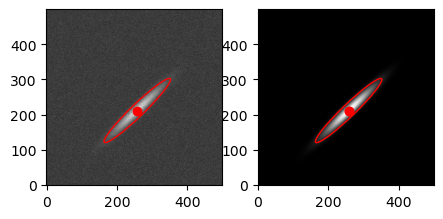

In [9]:
def draw_fit(ax, params):
    """Draw an ellipse on the given axis."""
    from matplotlib.patches import Ellipse

    ellipse = Ellipse(
        (params["x0"], params["y0"]),
        4 * params["sigma_x"],
        4 * params["sigma_y"],
        angle=np.degrees(params["theta"]),
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(ellipse)

    # center
    ax.plot(params["x0"], params["y0"], "ro")


# Generate example data (noisy 2D Gaussian)
nx, ny = 500, 500
xy = np.meshgrid(np.arange(nx), np.arange(ny))
true_params = {
    "amplitude": np.random.uniform(0.5, 1.5),
    "x0": np.random.uniform(200, 300),
    "y0": np.random.uniform(200, 300),
    "sigma_x": np.random.uniform(0, 50),
    "sigma_y": np.random.uniform(50, 100),
    "theta": np.random.uniform(-np.pi, np.pi),
    "offset": np.random.uniform(0, 0.05),
}
data = gaussian_2d(xy, **true_params) + np.random.normal(
    0, true_params["amplitude"] / 11, (ny, nx)
)

# Fit the Gaussian
params = fit_gaussian_2d(data)
fitted_data = gaussian_2d(xy, **params).reshape(data.shape)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].imshow(data, origin="lower", cmap="grey")

# draw centroid and sigmas
plt.plot([params["x0"]], [params["y0"]], "ro")
draw_fit(axes[0], params)

# plot the fitted Gaussian
axes[1].imshow(fitted_data, origin="lower", cmap="grey")
draw_fit(axes[1], params)

This appears to give somewhat reasonable values but...

- Sometimes it just doesnt work out
- Are we using a good definition of width etc
- Do we need angles etc? we should really be imaging pretty close to normal

We'd like to extract real data from this, can we use the fact these are 5ms appart and gravity acts downards to get a PIXEL_TO_REAL_SPACE value?

Then from that we should be able to get an expansion rate and temp?...